In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
import matplotlib.cm as cm
from matplotlib.lines import Line2D
import os
from os.path import join
import numpy as np
import pandas as pds
import seaborn as sns

In [25]:
path = os.path.dirname(os.path.abspath("__file__"))
data = pds.read_csv(join(path, 'ckine/data/pstat5_tensor.csv')) # Every row in the data represents a specific cell
numpy_data = data.values[:, 1:] # returns data values in a numpy array
cell_names = ['NK', 'NKT', 'CD3+CD8+','Naive CD8+','Mem CD8+', 'Tregs', 'Naive Treg', 'Mem Treg', 'T helper', 'Naive Th', 'Mem Th']

In [3]:
data.head()

,nM treatment,84,28,9.333333333,3.111111111,1.037037037,0.345679012,0.115226337,0.038408779,0.012802926,0.004267642,0.001422547,0.000474182
0,"IL-2, 4 hours",5882.0,5762.0,6767.0,9033.0,9765.0,8862.5,6828.0,5716.0,5257.5,5199.0,5031.0,5134.0
1,"IL-2, 2 hours",7098.0,10559.0,11316.5,10224.0,7591.0,5852.0,5196.0,5102.0,5079.0,4834.0,4594.0,4713.0
2,"IL-2, 1 hour",11606.0,11862.0,11327.5,10450.0,6479.5,5474.5,5082.0,5015.0,4759.0,4917.5,4892.0,4732.5
3,"IL-2, 30 min",11954.5,11509.0,11493.0,10615.0,6311.5,5301.0,4885.0,4780.0,4696.5,4530.0,4438.0,4639.5
4,"IL-15, 4 hours",5400.0,5471.0,5466.0,5464.0,5589.0,5247.0,4993.5,4272.5,3980.0,4137.0,4093.0,4367.0


In [4]:
#This reshapes the csv data into a form ready to reshape into a tensor
new_array = np.zeros((44,24))
for kk in range(44):
    new_array[kk] = np.concatenate((np.flip(numpy_data[kk*2 - kk%4]), np.flip(numpy_data[kk*2+4- kk%4])))

In [5]:
tensor = np.reshape(new_array, (11,4,24)) #reshape function can best do: cell type by time by ligand. Note the concentration order and time order. Flipping ensures ligand concentration in ascending order

In [6]:
tensor = np.flip(tensor, axis = 1) #Flips the tensor because Visterra gave them with higher times first. So flipping it would make them chronological. 

In [23]:
from ckine.figures.figureCommon import subplotLabel, getSetup, plot_cells, plot_ligands, values, mat, set_bounds
from ckine.figures.figure3 import plot_R2X
from ckine.Tensor_analysis import perform_decomposition

In [8]:
def plot_timepoints(ax, factors):
    """Function to put all timepoint plots in one figure."""
    ts = np.array([0.5, 1., 2., 4.])*60.    
    
    colors = ['b', 'k', 'r', 'y', 'm', 'g']
    for ii in range(factors.shape[1]):
        ax.plot(ts, factors[:, ii], c=colors[ii], label='Component ' + str(ii + 1))
        ax.scatter(ts[-1], factors[-1, ii], s=12, color='k')

    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Component')
    ax.set_title('Time')
    ax.legend()

In [44]:
def plot_ligands(ax, factors, component_x, component_y, ax_pos, n_ligands = 12):
    "This function is to plot the ligand combination dimension of the values tensor."
    markers = ['^', '*']
    cmap = sns.color_palette("hls", n_ligands)
    
    IL_treat = np.array([0.000474182, 0.001422547, 0.004267642, 0.012802926, 0.038408779, 0.115226337, 0.345679012,1.037037037, 3.111111111, 9.333333333,28,84 ])

    legend_shape = [Line2D([0], [0], color='k', marker=markers[0], label='IL-2', linestyle=''),
                    Line2D([0], [0], color='k', label='IL-15', marker=markers[1], linestyle='')]

    for ii in range(int(factors.shape[0] / n_ligands)):
        idx = range(ii * n_ligands, (ii + 1) * n_ligands)
        if ii == 0 and ax_pos == 2:
            legend = "full"
        else:
            legend = False
        sns.scatterplot(x=factors[idx, component_x - 1], y=factors[idx, component_y - 1], marker=markers[ii], hue=IL_treat, ax=ax, palette=cmap, s=100, legend=legend)
        h, l = ax.get_legend_handles_labels()
        if ax_pos == 2:
            legend1 = ax.legend(handles=h, loc=2)
            ax.add_artist(legend1)
            legend2 = ax.legend(handles=legend_shape, loc=3)
            ax.add_artist(legend2)

    ax.set_title('Ligands')
    set_bounds(ax, component_x)

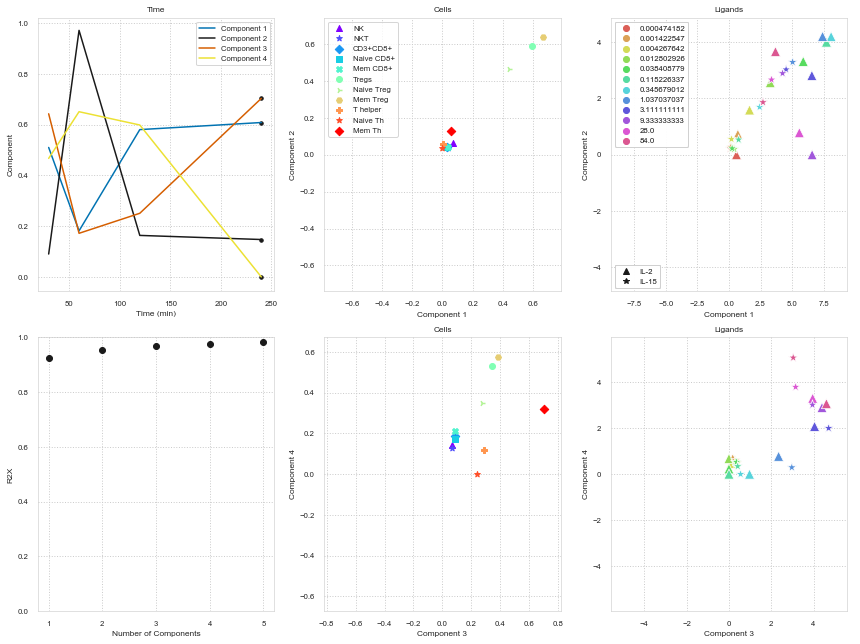

In [45]:
x, y = 2, 3
ax, f = getSetup((12, 9), (x, y))
factors_activity = []
for jj in range(len(mat) - 1):
    factors = perform_decomposition(tensor, jj + 1)
    factors_activity.append(factors)
plot_R2X(ax[3], tensor, factors_activity, n_comps=5)

n_comps = 4
factors_activ = factors_activity[n_comps - 1] #First dimension is cells. Second is time. Third is ligand. 
plot_timepoints(ax[0], factors_activ[1])


plot_cells(ax[1], factors_activ[0], 1, 2, cell_names, ax_pos=1)
plot_cells(ax[4], factors_activ[0], 3, 4, cell_names, ax_pos=4, fig3 = False)

plot_ligands(ax[2], factors_activ[2], 1, 2, ax_pos=2)
plot_ligands(ax[5], factors_activ[2], 3, 4, ax_pos=5)

f.tight_layout()